In [1]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
from time import time


In [2]:
# We will create num_arrays (= 200) random arrays
num_arrays = 200
array_len = 1024**2


In [3]:
ker = SourceModule("""       
__global__ void mult_ker(float * array, int array_len)
{
     int thd = blockIdx.x*blockDim.x + threadIdx.x;
     int num_iters = array_len / blockDim.x;
     for(int j=0; j < num_iters; j++)
     {
         int i = j * blockDim.x + thd;
         for(int k = 0; k < 50; k++)
         {
              array[i] *= 2.0;
              array[i] /= 2.0;
         }
     }
}
""")

mult_ker = ker.get_function('mult_ker')

In [4]:
data = []
data_gpu = []
gpu_out = []
streams = []
start_events = []
end_events = []


In [5]:
# We will process each array in a separate stream
for _ in range(num_arrays):
    streams.append(drv.Stream())
    start_events.append(drv.Event())
    end_events.append(drv.Event())


In [6]:
# generate random arrays.
for _ in range(num_arrays):
    data.append(np.random.randn(array_len).astype('float32'))


In [7]:
t_start = time()

# copy arrays to GPU. Async for each stream
for k in range(num_arrays):
    data_gpu.append(gpuarray.to_gpu_async(data[k], stream=streams[k]))

# process arrays. Async for each stream.
for k in range(num_arrays):
    start_events[k].record(streams[k])
    mult_ker(data_gpu[k], np.int32(array_len), block=(64,1,1), grid=(1,1,1), stream=streams[k])
for k in range(num_arrays):
    end_events[k].record(streams[k])
    
# copy arrays from GPU.
for k in range(num_arrays):
    gpu_out.append(data_gpu[k].get_async(stream=streams[k]))

t_end = time()

In [8]:
print('Total time: %f' % (t_end - t_start))

Total time: 0.422611


In [9]:
kernel_times = []

for k in range(num_arrays):
    kernel_times.append(start_events[k].time_till(end_events[k]))


print('Mean kernel duration (milliseconds): %f' % np.mean(kernel_times))
print('Mean kernel standard deviation (milliseconds): %f' % np.std(kernel_times))

Mean kernel duration (milliseconds): 50.389043
Mean kernel standard deviation (milliseconds): 24.563471


/home/barnabas/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


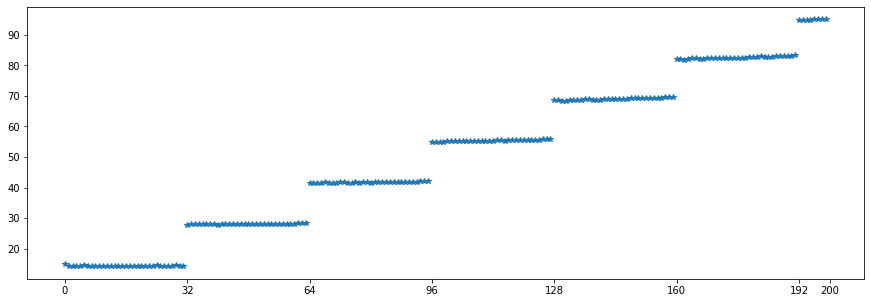

In [10]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(kernel_times, '*')
ax = plt.axes()
ax.set_xticks([0, 32, 64,96,128,160,192,200])


In [11]:
for k in range(num_arrays):
    assert (np.allclose(gpu_out[k], data[k]))
